In [1]:
import numpy as np
import glob 
import pickle
import datetime
import matplotlib.pyplot as plt
from matplotlib.path import Path
import cmocean.cm as cm
from os import path
from scipy.interpolate import griddata

%matplotlib inline

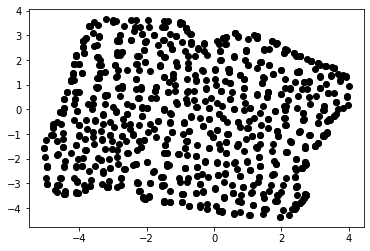

In [2]:
dt = 60.
res = 100.
npg = 64
npl = 9
fd = 20
f = 'D:/trial_sensitivity/fuzzyTrial_dt%1i_res%1i_npg%1i_npl%1i_fd%1i.pickle'%(dt,res,npg,npl,fd)
with open(f,'rb') as fid:
    data = pickle.load(fid,encoding='latin-1')
    
for xy in data[0.1]['xy'][-2:-1]:
    plt.scatter(xy[:,0].real,xy[:,0].imag,color='k')

(-1.0, 2.0)

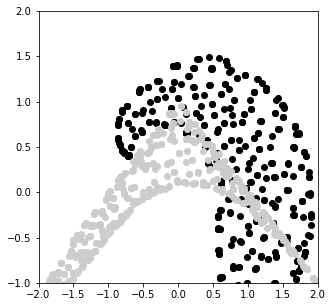

In [4]:
dt = 60.
res = 100.
npg = 64
npl = 9
fd = 11
f = 'D:/trial_sensitivity/fuzzyTrial_dt%1i_res%1i_npg%1i_npl%1i_fd%1i.pickle'%(dt,res,npg,npl,fd)
with open(f,'rb') as fid:
    data = pickle.load(fid,encoding='latin-1')
    
fig,ax = plt.subplots(figsize=(5,5))
for xy in data[0.1]['xy'][-2:-1]:
    ax.scatter(xy[:,0].real,xy[:,0].imag,color='k')
    ax.scatter(np.angle(xy[:,0]),1. - np.sqrt((np.absolute(xy[:,0]) - 1.)**2. + np.angle(xy[:,0])**2.),color='0.8')
    #ax.plot(np.arccos(np.cos(np.linspace(0.,2.*np.pi,360))),
#        np.arcsin(np.sin(np.linspace(0.,2.*np.pi,360))),color='r',lw=2)
ax.set_xlim(-2.,2.)
ax.set_ylim(-1.,2.)

In [5]:
def score_scenario(data,m=5.,beta=0.1):
    wscr = 0.
    for i,nl in enumerate([0.1,0.075,0.05,0.025]):
        xy = data[nl]['xy'][-1][:,0]
        scr = np.sum(np.abs(1. - np.sqrt((np.absolute(xy) - 1.)**2. + (np.angle(xy))**2.))) / len(xy)
        wscr += (i/m + beta) * scr

    wscr = wscr / np.sum(np.arange(m)/m + beta)
    
    return wscr

In [8]:
dt = 60.
res = 100.
npl = 7
fd = 11
npg = 64

#for npl in [5,7,9,11]:
#for npg in [16,32,64]:
#for res in [10,25,50,100]:
for fd in [11,13,15,17,20]:
    f = 'D:/trial_sensitivity/fuzzyTrial_dt%1i_res%1i_npg%1i_npl%1i_fd%1i.pickle'%(dt,res,npg,npl,fd)
    if path.exists(f):
        with open(f,'rb') as fid:
            data = pickle.load(fid,encoding='latin-1')
        wscr = score_scenario(data)
    print(fd,wscr)

11 0.29107070051361583
13 0.31331764207271945
15 0.3619453552051973
17 0.39373934291263685
20 0.5781830408499398


In [6]:
for res in [10,25,50,100]:
    print(res,len(glob.glob('./fuzzydrift_initial_trial/fuzzyTrial_dt15_res%1i_*'%res)))

10 16
25 30
50 45
100 45


In [9]:
def get_filled_data(data,snr,t,stdevmult=6.,holethres=7,holesearch=3):
    xg,yg = data[snr]['grid'][1:]
    xg = xg[t,:,:]
    yg = yg[t,:,:]

    z = np.zeros_like(xg)
    pts = data[snr]['xy'][t][:,0]
    for pt in pts:
        d = np.sqrt((xg - pt.real)**2. + (yg - pt.imag)**2.)
        j,i = np.where(d == d.min())
        z[j,i] = 1.

    for j in range(z.shape[0]):
        c = np.where(z[:,j] == 1.)[0]
        if len(c) > 1:
            diffcheck = np.diff(c)
            diffcheck[diffcheck == diffcheck.max()] = 0
            thres = int(stdevmult * np.nanstd(diffcheck))
            for i in range(len(c) - 1):
                if c[i+1] - c[i] < thres:
                    z[c[i]:c[i+1],j] = 1.

    for j in range(z.shape[0]):
        c = np.where(z[j,:] == 1.)[0]
        if len(c) > 1:
            diffcheck = np.diff(c)
            diffcheck[diffcheck == diffcheck.max()] = 0
            thres = int(stdevmult * np.nanstd(diffcheck))
            for i in range(len(c) - 1):
                if c[i+1] - c[i] < thres:
                    z[j,c[i]:c[i+1]] = 1.

    for a in range(holesearch):
        for j in range(z.shape[0]):
            for i in range(z.shape[1]):
                c1 = (z[j-holethres:j,i] == 1.).any()
                c2 = (z[j:j+holethres,i] == 1.).any()
                c3 = (z[j,i-holethres:i] == 1.).any()
                c4 = (z[j,i:i+holethres] == 1.).any()
                if np.logical_and(np.logical_and(c1,c2),np.logical_and(c3,c4)):
                    z[j,i] = 1.
                if np.logical_or(np.sum(z[j-1:j+2,i]) == 2.,np.sum(z[j,i-1:i+2]) == 2.):
                    z[j,i] = 1.
                    
    return z,xg,yg

In [10]:
def plot_set(ax,data,t):
    m = len(data)
    for i,snr in enumerate(sorted([float(k) for k in data.keys()])[::-1]):
        alph1,xg,yg = get_filled_data(data,snr,t)
        jj,ii = np.where(alph1 != 0.)
        alph1[jj,ii] = (i+1)/m
        if i == 0:
            alph = alph1
        else:
            alph[jj,ii] = alph1[jj,ii]

    alph[alph == 0.] = np.nan
    alph -= 1/m

    pc = ax.pcolormesh(xg,yg,np.ma.masked_where(np.isnan(alph),alph),cmap=cm.amp,vmin=0.,vmax=1.)
    ax.scatter(0.,1.,s=48,facecolor='w',edgecolor='k',lw=2)

    return pc

C:\Users\hauke\AppData\Local\Temp/ipykernel_28888/3921142637.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolormesh(xg,yg,np.ma.masked_where(np.isnan(alph),alph),cmap=cm.amp,vmin=0.,vmax=1.)


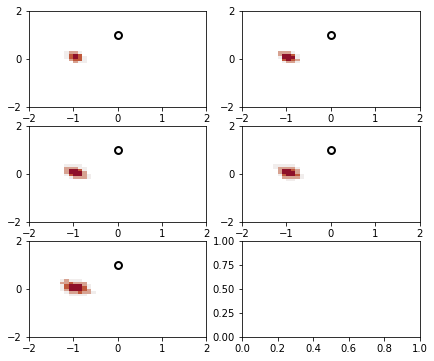

In [11]:
dt = 60.
res = 100.
npl = 7
fd = 11
npg = 16

#for npl in [5,7,9,11]:
#for npg in [16,32,64]:
#for res in [10,25,50,100]:
fig,axes = plt.subplots(3,2,figsize=(7,6))
for ax,fd in zip(axes.ravel()[:-1],[11,13,15,17,20]):
    f = 'D:/trial_sensitivity/fuzzyTrial_dt%1i_res%1i_npg%1i_npl%1i_fd%1i.pickle'%(dt,res,npg,npl,fd)
    if path.exists(f):
        with open(f,'rb') as fid:
            data = pickle.load(fid,encoding='latin-1')
            
        plot_set(ax,data,30)

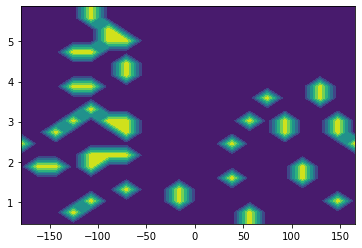

In [12]:
dat = data[0.1]
rad = np.absolute(dat['xy'][-1][:,0])
theta = np.arctan2(dat['xy'][-1][:,0].real,dat['xy'][-1][:,0].imag) * 180./np.pi

N = 20
x,y = np.meshgrid(np.linspace(theta.min(),theta.max(),N),np.linspace(rad.min(),rad.max(),N))
z = np.zeros_like(x)
for r,t in zip(rad,theta):
    d = np.sqrt((x - t)**2. + (y - r)**2.)
    j,i = np.where(d == d.min())
    z[j,i] = 1.
plt.contourf(x,y,z)

In [13]:
from scipy.spatial import ConvexHull

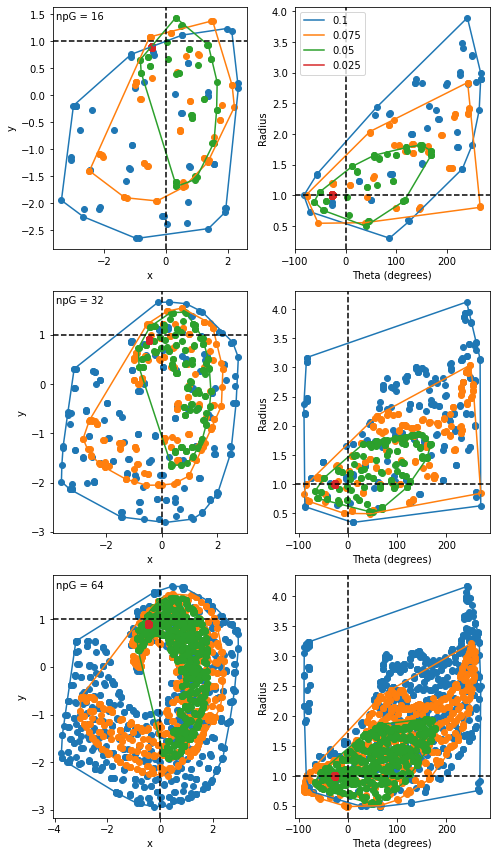

In [14]:
fig,axarray = plt.subplots(3,2,figsize=(7,12))

dt = 60.
res = 200.
npl = 7
fd = 15
npg = 16

#for npl in [5,7,9,11]:
for ai,npg in enumerate([16,32,64]):
    axes = axarray[ai,:]
#for res in [10,25,50,100]:
    f = 'D:/trial_sensitivity/fuzzyTrial_dt%1i_res%1i_npg%1i_npl%1i_fd%1i.pickle'%(dt,res,npg,npl,fd)
    if path.exists(f):
        with open(f,'rb') as fid:
            data = pickle.load(fid,encoding='latin-1')
            
    for ind,ax in enumerate(axes):
        for snr in sorted([float(k) for k in data.keys()])[::-1]:
            dat = data[snr]
            if ind:
                y = np.absolute(dat['xy'][-1][:,0])
                x = np.arctan2(dat['xy'][-1][:,0].real,dat['xy'][-1][:,0].imag) * 180./np.pi
                x[x < -90.] += 360.
            else:
                y = dat['xy'][-1][:,0].imag
                x = dat['xy'][-1][:,0].real

            pts = np.column_stack([x,y])
            hull = ConvexHull(pts)
            verts = pts[hull.vertices,:]
            verts = np.vstack([verts,verts[0,:]])

            ax.plot(verts[:,0],verts[:,1],label=str(snr))
            ax.scatter(pts[:,0],pts[:,1])
        if ind and ai == 0:
            ax.legend()
        ax.axhline(1.,color='k',ls='--')
        ax.axvline(0.,color='k',ls='--')

        if ind:
            ax.set_xlabel('Theta (degrees)')
            ax.set_ylabel('Radius')
        else:
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.text(0.02,0.98,'npG = %1i'%npg,ha='left',va='top',transform=ax.transAxes)
        
plt.tight_layout()
#plt.savefig('./npg_sensitivity.png',dpi=450,bbox_inches='tight')

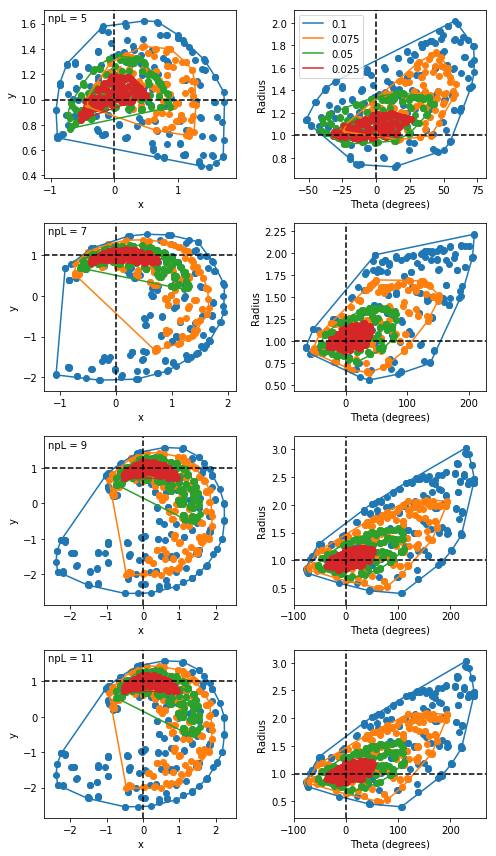

In [51]:
fig,axarray = plt.subplots(4,2,figsize=(7,12))

dt = 15.
res = 100.
npl = 7
fd = 15
npg = 32

#for npl in [5,7,9,11]:
for ai,npl in enumerate([5,7,9,11]):
    axes = axarray[ai,:]
#for res in [10,25,50,100]:
    f = './fuzzydrift_initial_trial/fuzzyTrial_dt%1i_res%1i_npg%1i_npl%1i_fd%1i.pickle'%(dt,res,npg,npl,fd)
    if path.exists(f):
        with open(f,'rb') as fid:
            data = pickle.load(fid,encoding='latin-1')
            
    for ind,ax in enumerate(axes):
        for snr in sorted([float(k) for k in data.keys()])[::-1]:
            dat = data[snr]
            if ind:
                y = np.absolute(dat['xy'][-1][:,0])
                x = np.arctan2(dat['xy'][-1][:,0].real,dat['xy'][-1][:,0].imag) * 180./np.pi
                x[x < -90.] += 360.
            else:
                y = dat['xy'][-1][:,0].imag
                x = dat['xy'][-1][:,0].real

            pts = np.column_stack([x,y])
            hull = ConvexHull(pts)
            verts = pts[hull.vertices,:]
            verts = np.vstack([verts,verts[0,:]])

            ax.plot(verts[:,0],verts[:,1],label=str(snr))
            ax.scatter(pts[:,0],pts[:,1])
        if ind and ai == 0:
            ax.legend()
        ax.axhline(1.,color='k',ls='--')
        ax.axvline(0.,color='k',ls='--')

        if ind:
            ax.set_xlabel('Theta (degrees)')
            ax.set_ylabel('Radius')
        else:
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.text(0.02,0.98,'npL = %1i'%npl,ha='left',va='top',transform=ax.transAxes)
        
plt.tight_layout()
plt.savefig('../npl_sensitivity.png',dpi=450,bbox_inches='tight')

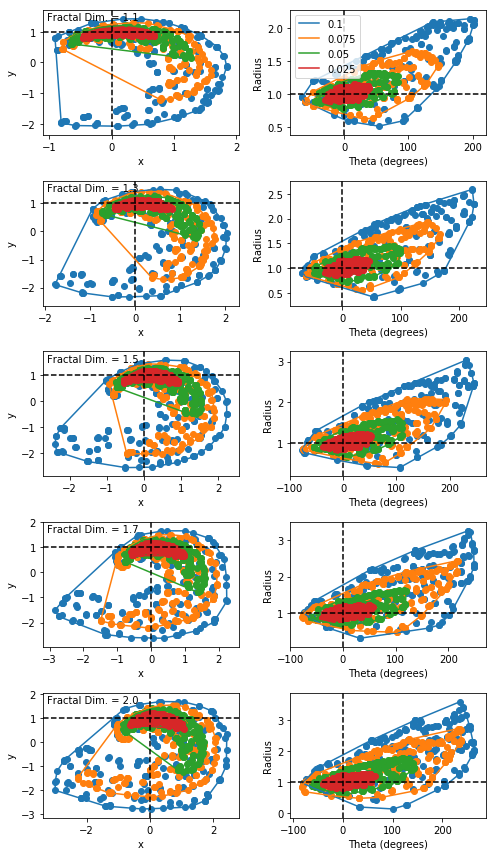

In [55]:
fig,axarray = plt.subplots(5,2,figsize=(7,12))

dt = 15.
res = 100.
npl = 9
fd = 15
npg = 32

#for npl in [5,7,9,11]:
for ai,fd in enumerate([11,13,15,17,20]):
    axes = axarray[ai,:]
#for res in [10,25,50,100]:
    f = './fuzzydrift_initial_trial/fuzzyTrial_dt%1i_res%1i_npg%1i_npl%1i_fd%1i.pickle'%(dt,res,npg,npl,fd)
    if path.exists(f):
        with open(f,'rb') as fid:
            data = pickle.load(fid,encoding='latin-1')
            
    for ind,ax in enumerate(axes):
        for snr in sorted([float(k) for k in data.keys()])[::-1]:
            dat = data[snr]
            if ind:
                y = np.absolute(dat['xy'][-1][:,0])
                x = np.arctan2(dat['xy'][-1][:,0].real,dat['xy'][-1][:,0].imag) * 180./np.pi
                x[x < -90.] += 360.
            else:
                y = dat['xy'][-1][:,0].imag
                x = dat['xy'][-1][:,0].real

            pts = np.column_stack([x,y])
            hull = ConvexHull(pts)
            verts = pts[hull.vertices,:]
            verts = np.vstack([verts,verts[0,:]])

            ax.plot(verts[:,0],verts[:,1],label=str(snr))
            ax.scatter(pts[:,0],pts[:,1])
        if ind and ai == 0:
            ax.legend()
        ax.axhline(1.,color='k',ls='--')
        ax.axvline(0.,color='k',ls='--')

        if ind:
            ax.set_xlabel('Theta (degrees)')
            ax.set_ylabel('Radius')
        else:
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.text(0.02,0.98,'Fractal Dim. = %.1f'%(fd/10.),ha='left',va='top',transform=ax.transAxes)
        
plt.tight_layout()
plt.savefig('./fd_sensitivity.png',dpi=450,bbox_inches='tight')

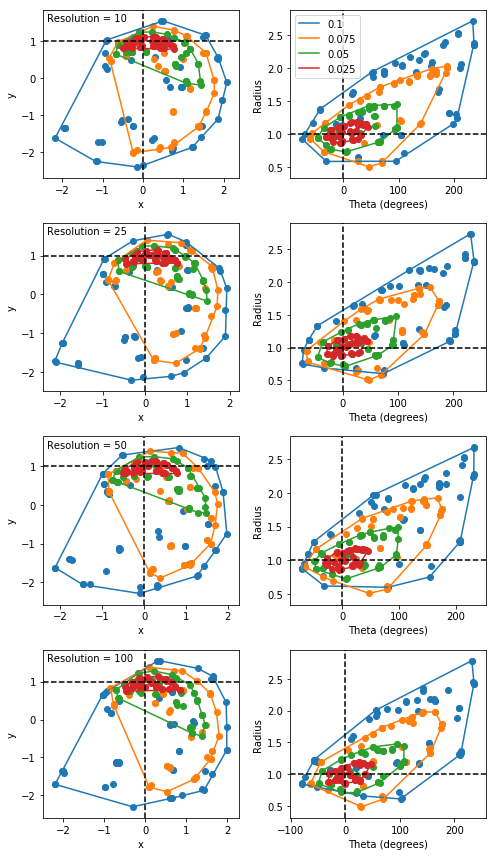

In [56]:
fig,axarray = plt.subplots(4,2,figsize=(7,12))

dt = 15.
res = 100.
npl = 9
fd = 15
npg = 16

#for npl in [5,7,9,11]:
for ai,res in enumerate([10,25,50,100]):
    axes = axarray[ai,:]
#for res in [10,25,50,100]:
    f = './fuzzydrift_initial_trial/fuzzyTrial_dt%1i_res%1i_npg%1i_npl%1i_fd%1i.pickle'%(dt,res,npg,npl,fd)
    if path.exists(f):
        with open(f,'rb') as fid:
            data = pickle.load(fid,encoding='latin-1')
            
    for ind,ax in enumerate(axes):
        for snr in sorted([float(k) for k in data.keys()])[::-1]:
            dat = data[snr]
            if ind:
                y = np.absolute(dat['xy'][-1][:,0])
                x = np.arctan2(dat['xy'][-1][:,0].real,dat['xy'][-1][:,0].imag) * 180./np.pi
                x[x < -90.] += 360.
            else:
                y = dat['xy'][-1][:,0].imag
                x = dat['xy'][-1][:,0].real

            pts = np.column_stack([x,y])
            hull = ConvexHull(pts)
            verts = pts[hull.vertices,:]
            verts = np.vstack([verts,verts[0,:]])

            ax.plot(verts[:,0],verts[:,1],label=str(snr))
            ax.scatter(pts[:,0],pts[:,1])
        if ind and ai == 0:
            ax.legend()
        ax.axhline(1.,color='k',ls='--')
        ax.axvline(0.,color='k',ls='--')

        if ind:
            ax.set_xlabel('Theta (degrees)')
            ax.set_ylabel('Radius')
        else:
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.text(0.02,0.98,'Resolution = %1i'%res,ha='left',va='top',transform=ax.transAxes)
        
plt.tight_layout()
plt.savefig('./res_sensitivity.png',dpi=450,bbox_inches='tight')

In [73]:
def get_edge_paths(data,thres=None):
    paths = {}
    for noise in data.keys():
        paths[noise] = {}
        for t in range(len(data[noise]['xy']) - 1):
            closeside = []
            farside = []
            tsort = []
            x = data[noise]['xy'][t+1][:,0].real
            y = data[noise]['xy'][t+1][:,0].imag
            if thres is None:
                #thres = 6. * noise * np.std(np.sqrt(np.diff(x)**2. + np.diff(y)**2.))
                thres = 0.25 * len(x) * np.std(np.sqrt(np.diff(x)**2. + np.diff(y)**2.)) / (1. - 2. * noise)**12.
            for theta in np.linspace(0.,2.*np.pi,720):
                xp = x * np.cos(theta) - y * np.sin(theta)
                yp = x * np.sin(theta) + y * np.cos(theta)
                c = np.where(np.logical_and(xp > 0.,np.abs(yp) < thres))[0]
                if len(c) == 0:
                    continue
                else:
                    r = np.sqrt(x[c]**2. + y[c]**2.)
                    p1 = np.array([x[c][r == r.min()],y[c][r == r.min()]]).T[0]
                    p2 = np.array([x[c][r == r.max()],y[c][r == r.max()]]).T[0]
                    closeside.append(p1)
                    farside.append(p2)
                    if theta <= np.pi:
                        tsort.append(theta)
                    else:
                        tsort.append(theta - 2 * np.pi)
            sorting = np.asarray(tsort).argsort()
            
            closeside = np.asarray(closeside)[sorting]
            farside = np.asarray(farside)[sorting]
            pts = np.vstack([closeside,farside[::-1,:]])
            bb = Path(pts)

            paths[noise][t] = {'pts':pts,'path':bb}

    return paths

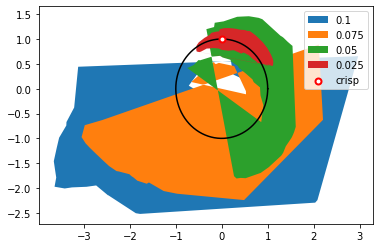

In [74]:
paths = get_edge_paths(data,thres=None)
for n in [0.1,0.075,0.05,0.025]:
    pts = paths[n][119]['pts']
    plt.fill(pts[:,0],pts[:,1],label=str(n),zorder=1000)
plt.scatter(0.,1.,facecolor='w',edgecolor='r',lw=2,label='crisp',zorder=1002)
leg = plt.legend()
leg.set_zorder(1002)
plt.plot(np.cos(np.linspace(0.,2.*np.pi,360)),np.sin(np.linspace(0.,2.*np.pi,360)),color='k',zorder=1001)

16 0.268335
32 0.42052500000000004
64 0.5153625000000001


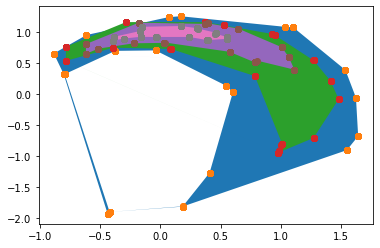

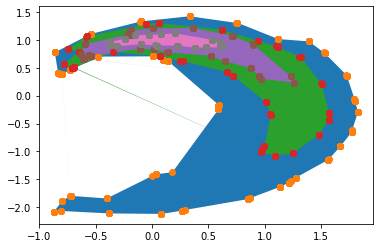

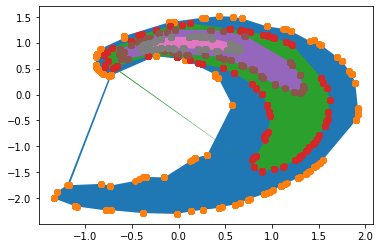

In [83]:
ext = 3.
N = 200 #500
resg = 2. * ext / N

dt = 60.
res = 100.
npl = 9
fd = 11
npg = 16

#for npl in [5,7,9,11]:
for npg in [16,32,64]:
#for res in [10,25,50,100]:
    f = 'D:/trial_sensitivity/fuzzyTrial_dt%1i_res%1i_npg%1i_npl%1i_fd%1i.pickle'%(dt,res,npg,npl,fd)
    if path.exists(f):
        with open(f,'rb') as fid:
            data = pickle.load(fid,encoding='latin-1')
            
        try:
            paths = get_edge_paths(data,thres=(8./npg)**0.25)
            fig,ax = plt.subplots()
            x,y = np.meshgrid(np.linspace(-ext,ext,N),np.linspace(-ext,ext,N))
            z = np.zeros_like(x)
            for n in [0.1,0.075,0.05,0.025]:
                bb = paths[n][119]['path']
                pts = paths[n][119]['pts']
                ax.fill(pts[:,0],pts[:,1],zorder=1000)
                ax.scatter(pts[:,0],pts[:,1],zorder=1001)
                for j in range(x.shape[0]):
                    for i in range(x.shape[1]):
                        if bb.contains_point((x[j,i],y[j,i])):
                            z[j,i] = n
            z = z * resg**2.
            #ax.pcolormesh(x,y,np.ma.masked_where(z == 0.,z),cmap=cm.amp)
            print(npg,np.sum(z))
        except:
            print('No edge paths for %s'%f)

In [28]:
ext = 3.
N = 500
resg = 2. * ext / N

dt = 15.
res = 100.
npl = 9
fd = 15
npg = 32

for npl in [5,7,9,11]:
#for npg in [16,32,64]:
#for res in [10,25,50,100]:
    f = './fuzzydrift_initial_trial/fuzzyTrial_dt%1i_res%1i_npg%1i_npl%1i_fd%1i.pickle'%(dt,res,npg,npl,fd)
    if path.exists(f):
        with open(f,'rb') as fid:
            data = pickle.load(fid,encoding='latin-1')
            
        try:
            paths = get_edge_paths(data)
            x,y = np.meshgrid(np.linspace(-ext,ext,N),np.linspace(-ext,ext,N))
            z = np.zeros_like(x)
            for n in [0.1,0.075,0.05,0.025]:
                bb = paths[n][29]['path']
                for j in range(x.shape[0]):
                    for i in range(x.shape[1]):
                        if bb.contains_point((x[j,i],y[j,i])):
                            z[j,i] = n
            z = z * resg**2.
            print(npl,np.sum(z))
        except:
            print('No edge paths for %s'%f)

5 0.1720584
7 0.5667408
9 0.9297180000000002


In [29]:
ext = 3.
N = 500
resg = 2. * ext / N

dt = 15.
res = 100.
npl = 9
fd = 15
npg = 16

#for npl in [5,7,9,11]:
#for npg in [16,32,64]:
for res in [10,25,50,100]:
    f = './fuzzydrift_initial_trial/fuzzyTrial_dt%1i_res%1i_npg%1i_npl%1i_fd%1i.pickle'%(dt,res,npg,npl,fd)
    if path.exists(f):
        with open(f,'rb') as fid:
            data = pickle.load(fid,encoding='latin-1')
            
        try:
            paths = get_edge_paths(data)
            x,y = np.meshgrid(np.linspace(-ext,ext,N),np.linspace(-ext,ext,N))
            z = np.zeros_like(x)
            for n in [0.1,0.075,0.05,0.025]:
                bb = paths[n][29]['path']
                for j in range(x.shape[0]):
                    for i in range(x.shape[1]):
                        if bb.contains_point((x[j,i],y[j,i])):
                            z[j,i] = n
            z = z * resg**2.
            print(res,np.sum(z))
        except:
            print('No edge paths for %s'%f)

10 0.9666107999999998
25 0.8551044
50 0.7020107999999999
100 0.7272792
